## Imports

In [1]:
import os
import sys
import pathlib

import cv2
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

import torchvision
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt 
import albumentations as albu

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

# Fix to be able to import python modules inside a notebook
os.chdir('..')

# Useful extensions
# %load_ext watermark
# %watermark -v -n -m -p numpy,torch,albumentations,photosynthesis_metrics

%load_ext autoreload
%autoreload 2

# Nice plot formating
%matplotlib inline

In [3]:
!ls

configs  logs	   notebooks   preprocess.py  requirements.txt	train.py
data	 Makefile  predict.py  README.md      src


In [11]:
from loguru import logger
import albumentations.pytorch as albu_pt
class Dataset(torch.utils.data.Dataset):
    _aspect_ratios = np.array([2, 16 / 9, 3 / 2, 4 / 3, 5 / 4, 1, 4 / 5, 3 / 4, 2 / 3, 9 / 16, 1 / 2])

    def __init__(self, root="data/interim", transform=None, train=None, size=512):
        df = pd.read_csv(os.path.join(root, "train_val.csv"))
        
        if train is not None:
            df = df[df["is_train"].astype(np.bool) == train]
    
        self.filenames = [
            os.path.join(root, f"train_data_{size}", path) for path in df["file_path"].values.tolist()]

        # Сheck that all images exist
        assert map(lambda x: pathlib.Path(x).exists(), self.filenames), "Found missing images!"

        self.targets = df["label"].values.tolist()
        self.ar = df["aspect_ratio"].values

        # For each aspect ration in `ar` find closest value from the
        # `_aspect_ratios` and return it's index (group)
        self.group_ids = np.argmin(
            np.abs(self._aspect_ratios.reshape(1, -1) - self.ar.reshape(-1, 1)),
            axis=1
        )

        self.sizes = []
        for group in self.group_ids:
            ar = self._aspect_ratios[group]
            # Resize image to have `size` shape on smaller side and be devidable by 16 on another
            if ar <= 1:
                H = size
                W = int(size / ar) // 8 * 8
            else:
                W = size
                H = int(size * ar) // 8 * 8
            self.sizes.append((H, W))

        logger.info(f"Using sizes {set(self.sizes)} for {'train'if train else 'validation'}")
        self.transform = albu.Compose([albu_pt.ToTensorV2()]) if transform is None else transform

    def __getitem__(self, index):
        """
        Args:
            index (int): Index
        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        # logger.info(f"Index {index}")
        image = cv2.imread(self.filenames[index], cv2.IMREAD_COLOR)
        # logger.info(f"{index} Size before reshape {image.shape}")
        image = cv2.resize(image, self.sizes[index])
        # logger.info(f"{index} Size after reshape {image.shape}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transform(image=image)["image"]

        target = self.targets[index]

        return image, target

    def __len__(self):
        return len(self.filenames)

In [23]:
from src.augmentations import get_aug
from src.utils import ToCudaLoader
from src.datasets import GroupedBatchSampler

aug = get_aug('val', size=512)
BATCH_SIZE = 1

dataset = Dataset(root="data/interim", transform=aug, train=None, size=512)

gb_sampler = GroupedBatchSampler(
    sampler=torch.utils.data.sampler.SequentialSampler(dataset),
    group_ids=dataset.group_ids,
    batch_size=BATCH_SIZE,
    drop_uneven=False,
)

loader = torch.utils.data.DataLoader(
    dataset,
    num_workers=8,
    pin_memory=False,
    batch_sampler=gb_sampler,
)

loader = ToCudaLoader(loader)
logger.info(f"Len dataset {len(dataset)}")

# GB sampler changes the order of images depending on batch size
indexes = [idx for batch in list(gb_sampler) for idx in batch]


2020-09-19 17:46:20.032 | INFO     | __main__:__init__:40 - Using sizes {(768, 512), (512, 512), (640, 512), (512, 1024), (512, 768), (1024, 512), (512, 640), (680, 512), (904, 512), (512, 904), (512, 680)} for validation
2020-09-19 17:46:20.043 | INFO     | __main__:<module>:25 - Len dataset 68601


In [24]:
from predict import predict_from_loader
from src.models import Model
import pathlib

# Get model
model = Model(
    arch="genet_small",
    model_params={},
    embedding_size=512,
    pooling="gem").cuda()
# logger.info(model)

# Init
checkpoint = torch.load(pathlib.Path("logs/genet_small_384_light_arcface80_1") / f"model.chpn")
model.load_state_dict(checkpoint["state_dict"], strict=False)

<All keys matched successfully>

In [25]:
embeddings = predict_from_loader(model, loader)
embeddings = torch.tensor(embeddings)

100%|██████████| 68601/68601 [08:58<00:00, 127.48it/s]


In [208]:
df = pd.read_csv("data/interim/train_val.csv")

# With BS=1 df should be same 
df = df.iloc[indexes]

# Hack to save torch.Tensor into pd.DataFrame
df["embeddings"] = list(map(lambda r: np.array(r).tolist(), embeddings))
df.head(3)

,file_path,label,full_path,hash_md5,original_size,aspect_ratio,is_train,is_query,embeddings
0,DIGIX_000000/19BRS2LZXV4M865W.jpg,0,data/raw/train_data/DIGIX_000000/19BRS2LZXV4M8...,b2a51756bcc2747e9c2b1705e2698c48,"(1080, 1440)",0.75,False,True,"[0.01711384207010269, 0.03588671609759331, 0.0..."
1,DIGIX_000000/4M83NC5JGYK0SP2Q.jpg,0,data/raw/train_data/DIGIX_000000/4M83NC5JGYK0S...,bbb1b8013cf2b3070504e7430413a9f1,"(800, 800)",1.00,False,True,"[-0.09386199712753296, 0.02441553771495819, 0...."
2,DIGIX_000000/5W97AIZ2CE43XHQD.jpg,0,data/raw/train_data/DIGIX_000000/5W97AIZ2CE43X...,61229d8d436ebbae740b345c8e07b7df,"(800, 800)",1.00,False,False,"[-0.03274247422814369, -0.03547808900475502, 0..."


In [256]:
merged_clases = []

In [249]:
global ignore_labels
ignore_labels = []

In [291]:
import collections
# Sort to always have the same order
unique_labels = sorted(df["label"].unique())
                      
def show_similar(query_label, df, embeddings, topk=5, refresh=True, merge1=False, merge2=False, merge3=False, force=False):
    if (query_label in ignore_labels) and not force :
        print("Duplicate class")
        return
    
    
    embeddings = torch.tensor(embeddings)
    query_df = df[df["label"] == query_label]
    gallery_df = df[df["label"] != query_label]
    query_embeddings = embeddings[query_df.index]
    gallery_embeddings = embeddings[gallery_df.index]
#     print(len(query_embeddings), len(gallery_embeddings))
    
    distances = torch.cdist(query_embeddings, gallery_embeddings)
#     perm_matrix = torch.argsort(distances)[..., :10]
    sort, perm_matrix = torch.sort(distances)
    perm_matrix = perm_matrix[..., :10]
#     print(sort[...,:3])
    
    gallery_labels = gallery_df.iloc[perm_matrix.flatten().numpy()]["label"].values
    counter = collections.Counter(gallery_labels).most_common()[:topk]
    
#     print(counter)
    
    # Sample random image from query label and random images from each simmilar label
    query_file = query_df.sample(1)["file_path"].values[0]
    gallery_files = [gallery_df[gallery_df["label"] == label].sample(1)["file_path"].values[0] for (label, count) in counter]
#     print(query_file, gallery_files, len(gallery_files))
    
    query = cv2.imread(os.path.join("data/interim/train_data_384/", query_file))
    query = cv2.cvtColor(query, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(20,15))
    plt.subplot(1, topk + 1, 1)
    plt.imshow(query)
    print("image class", query_label)
    
    for i, (label, count) in enumerate(counter):
        print(label, count)
        image = cv2.imread(os.path.join("data/interim/train_data_384/", gallery_files[i]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(1, topk + 1, i + 2)
        plt.imshow(image)
    
    if merge1:
        merged_clases.append((query_label, counter[0][0]))
        ignore_labels.append(counter[0][0])

    if merge2:
        merged_clases.append((query_label, counter[1][0]))
        ignore_labels.append(counter[1][0])
        
    if merge3:
        merged_clases.append((query_label, counter[2][0]))
        ignore_labels.append(counter[2][0])
        
#     if merge4:
#         merged_clases.append((query_label, counter[3][0]))
#         ignore_labels.append(counter[3][0])
        
#     if merge5:
#         merged_clases.append((query_label, counter[4][0]))
#         ignore_labels.append(counter[4][0])
#     print(merged_clases)

In [287]:
# set(range(3096)) - set(unique_labels)

In [310]:
from ipywidgets import interact, interactive, fixed, interact_manual

TOPK = 3

interact(show_similar, query_label=unique_labels, topk=fixed(TOPK), df=fixed(df), embeddings=fixed(embeddings))
# unique_labels = unique_labels[1:]

interactive(children=(Dropdown(description='query_label', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1…

<function __main__.show_similar(query_label, df, embeddings, topk=5, refresh=True, merge1=False, merge2=False, merge3=False, force=False)>

In [322]:
len(merged_clases)

252

In [323]:
merged_clases, ignore_labels

([(4, 1358),
  (25, 2852),
  (29, 747),
  (29, 574),
  (36, 2999),
  (43, 2687),
  (44, 2505),
  (51, 238),
  (67, 534),
  (69, 1218),
  (75, 1192),
  (88, 402),
  (89, 1260),
  (90, 2942),
  (95, 3053),
  (97, 1299),
  (108, 1158),
  (108, 2972),
  (108, 700),
  (122, 2208),
  (124, 2394),
  (139, 2706),
  (140, 180),
  (149, 2150),
  (149, 2169),
  (164, 1953),
  (165, 930),
  (176, 1180),
  (179, 418),
  (183, 1946),
  (187, 145),
  (189, 415),
  (189, 1568),
  (189, 1568),
  (189, 87),
  (189, 87),
  (190, 1189),
  (190, 461),
  (190, 3023),
  (193, 2398),
  (194, 409),
  (202, 498),
  (210, 525),
  (210, 525),
  (210, 2612),
  (222, 1676),
  (228, 3026),
  (228, 1616),
  (228, 1855),
  (245, 2975),
  (308, 2779),
  (325, 2333),
  (338, 628),
  (339, 1339),
  (348, 2072),
  (352, 545),
  (363, 1475),
  (363, 1908),
  (387, 2581),
  (391, 2242),
  (392, 1497),
  (429, 1298),
  (429, 1298),
  (429, 3033),
  (429, 1298),
  (443, 1663),
  (443, 1337),
  (445, 1944),
  (452, 1852),
  (4

In [325]:
# copy_merged = merged_clases

In [328]:
# Make smallest value always firs
# [(x,y) if x < y else (y, x) for (x,y) in merged_clases]

In [331]:
result = []


In [332]:
p = []
p.extend()

TypeError: extend() takes exactly one argument (0 given)

In [339]:
len(merged_clases)

252

In [343]:
LABEL_MAP = {
    2979: 1475,
    1528: 1475,
    2113: 2672,
    1695: 2860,
    188: 1011,
    1697: 2714,
    499: 1937,
    1009: 1658,
    1534: 2244,
    1077: 1767,
    74: 1635,
    381: 2139,
    942: 2812,
    1082: 770,
    1205: 770,
    822: 2170,
    414: 939,
    30: 1390,
    841: 1663,
    756: 1870,
    968: 1807,
}


merged_clases.extend(LABEL_MAP.items())

In [344]:
result = []
for pair in tqdm(merged_clases):
    extended = False
    for classes in result:
        if pair[0] in classes or pair[1] in classes:
            classes.extend(pair)
            extended = True
    # If class with pair not found, create one
    if not extended:
        result.append(list(pair))
        
result = [set(p) for p in result]

In [347]:
dict([(3,4), (1,2)])

{3: 4, 1: 2}

In [350]:
dict_mapping = []
for label_set in result:
    for label in label_set:
        dict_mapping.append((label, min(label_set)))
        
dict(dict_mapping)

{4: 4,
 1358: 4,
 25: 25,
 2852: 25,
 747: 29,
 29: 29,
 574: 29,
 2814: 36,
 36: 36,
 828: 36,
 2999: 36,
 43: 43,
 2687: 43,
 2505: 44,
 44: 44,
 1110: 51,
 51: 51,
 238: 51,
 67: 67,
 534: 67,
 1218: 69,
 69: 69,
 1192: 75,
 75: 75,
 88: 88,
 402: 88,
 89: 89,
 1260: 89,
 90: 90,
 2942: 90,
 3053: 95,
 95: 95,
 97: 97,
 657: 97,
 1299: 97,
 700: 700,
 1380: 700,
 1158: 700,
 108: 108,
 561: 108,
 985: 700,
 2972: 700,
 2208: 122,
 122: 122,
 2394: 124,
 124: 124,
 2706: 139,
 139: 139,
 180: 140,
 140: 140,
 2169: 149,
 149: 149,
 2150: 149,
 1953: 164,
 164: 164,
 930: 165,
 165: 165,
 176: 176,
 1180: 176,
 418: 179,
 179: 179,
 1946: 183,
 183: 183,
 145: 145,
 187: 145,
 1568: 87,
 189: 87,
 87: 87,
 415: 87,
 461: 190,
 1189: 190,
 190: 190,
 3023: 190,
 193: 193,
 2398: 193,
 409: 194,
 194: 194,
 202: 202,
 498: 202,
 210: 210,
 2612: 210,
 525: 210,
 1676: 222,
 222: 222,
 228: 228,
 1616: 228,
 1265: 228,
 3026: 228,
 1855: 228,
 483: 245,
 245: 245,
 894: 245,
 2975: 245,


In [330]:
sorted(merged_clases, key=lambda x: x[1])

[(1836, 35),
 (1919, 42),
 (1832, 73),
 (189, 87),
 (189, 87),
 (561, 108),
 (489, 117),
 (187, 145),
 (140, 180),
 (2031, 200),
 (1265, 228),
 (804, 235),
 (51, 238),
 (1110, 238),
 (1130, 296),
 (807, 299),
 (2172, 307),
 (836, 311),
 (682, 313),
 (843, 374),
 (88, 402),
 (194, 409),
 (189, 415),
 (179, 418),
 (1238, 419),
 (1542, 427),
 (1070, 441),
 (2147, 443),
 (626, 453),
 (190, 461),
 (1789, 486),
 (1169, 495),
 (202, 498),
 (733, 500),
 (567, 501),
 (210, 525),
 (210, 525),
 (67, 534),
 (491, 539),
 (1016, 539),
 (1226, 539),
 (352, 545),
 (29, 574),
 (1438, 589),
 (338, 628),
 (2055, 628),
 (589, 636),
 (1438, 636),
 (685, 658),
 (491, 672),
 (1016, 672),
 (1226, 672),
 (484, 674),
 (108, 700),
 (985, 700),
 (1380, 700),
 (29, 747),
 (1245, 763),
 (483, 894),
 (599, 912),
 (655, 912),
 (1415, 913),
 (165, 930),
 (658, 939),
 (685, 939),
 (696, 964),
 (713, 1001),
 (631, 1030),
 (1776, 1081),
 (1248, 1095),
 (913, 1102),
 (1415, 1102),
 (776, 1105),
 (516, 1127),
 (685, 1128),

In [329]:
sorted(merged_clases)

[(4, 1358),
 (25, 2852),
 (29, 574),
 (29, 747),
 (36, 2999),
 (43, 2687),
 (44, 2505),
 (51, 238),
 (67, 534),
 (69, 1218),
 (75, 1192),
 (88, 402),
 (89, 1260),
 (90, 2942),
 (95, 3053),
 (97, 1299),
 (108, 700),
 (108, 1158),
 (108, 2972),
 (122, 2208),
 (124, 2394),
 (139, 2706),
 (140, 180),
 (149, 2150),
 (149, 2169),
 (164, 1953),
 (165, 930),
 (176, 1180),
 (179, 418),
 (183, 1946),
 (187, 145),
 (189, 87),
 (189, 87),
 (189, 415),
 (189, 1568),
 (189, 1568),
 (190, 461),
 (190, 1189),
 (190, 3023),
 (193, 2398),
 (194, 409),
 (202, 498),
 (210, 525),
 (210, 525),
 (210, 2612),
 (222, 1676),
 (228, 1616),
 (228, 1855),
 (228, 3026),
 (245, 2975),
 (308, 2779),
 (325, 2333),
 (338, 628),
 (339, 1339),
 (348, 2072),
 (352, 545),
 (363, 1475),
 (363, 1908),
 (387, 2581),
 (391, 2242),
 (392, 1497),
 (397, 1994),
 (429, 1298),
 (429, 1298),
 (429, 1298),
 (429, 3033),
 (443, 1337),
 (443, 1663),
 (445, 1944),
 (452, 1852),
 (467, 1672),
 (474, 2983),
 (483, 894),
 (483, 2975),
 (48

In [211]:
mean_embeddings = []

for label in unique_labels:
    label_df = df[df["label"] == label]
    label_embeddings = embeddings[label_df.index]
    mean_label_embedding = torch.nn.functional.normalize(label_embeddings.sum(dim=0), p=2, dim=-1)
#     print(mean_label_embedding.shape)
    mean_embeddings.append(mean_label_embedding)

mean_embeddings = torch.stack(mean_embeddings)
distances = torch.cdist(mean_embeddings, mean_embeddings)

In [223]:
MARGIN = 0.9
sorted_distances, perm_matrix = torch.sort(distances)
close_labels = (sorted_distances < MARGIN) * perm_matrix
close_labels = close_labels[..., :10]
close_labels = close_labels[close_labels.sum(dim=1) > torch.tensor(unique_labels)]
print(len(close_labels))
# close_labels

1054


In [224]:
#  df[df["label"] == ]

In [225]:
def merge_labels(idx, close_labels, merge=False):
    l = close_labels[idx]
    query_label = int(l[0])
    gallery_labels = [int(x) for x in l[1:] if x > 0]
    print(query_label, gallery_labels)
    
    # Sample random image from query label and random images from each similar label
#     print(df[df["label"] == query_label])
    query_file = df[df["label"] == query_label].sample(1)["full_path"].values[0]
    gallery_files = [df[df["label"] == label].sample(1)["full_path"].values[0] for label in gallery_labels]    

    query = cv2.imread(query_file)
    query = cv2.cvtColor(query, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(10,10))
    plt.subplot(1, len(gallery_files) + 1, 1)
    plt.imshow(query)
    print("image class", query_label)
    
    for i in range(len(gallery_files)):
        print(gallery_labels[i])
        image = cv2.imread(gallery_files[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(1, len(gallery_files) + 1, i + 2)
        plt.imshow(image)
   

In [229]:
 
# perm_matrix = perm_matrix[..., :5]
interact(merge_labels, idx=range(len(close_labels)), close_labels=fixed(close_labels))

interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

<function __main__.merge_labels(idx, close_labels, merge=False)>

In [49]:
# 1. Mean embeddings
        
    


# query_file = os.path.join("data/interim/test_data_A_384/query", df.iloc[query_idx].values[0])
#     gallery_files = [os.path.join("data/interim/test_data_A_384/gallery", path) for path in df.iloc[query_idx].values[1:]]
# #     print(query_file, "\n", gallery_files)
#     query = cv2.imread(query_file)
#     query = cv2.cvtColor(query, cv2.COLOR_BGR2RGB)
    
#     plt.figure(figsize=(20,15))
#     plt.subplot(1, 11, 1)
#     plt.imshow(query)
#     for i in range(10):
#         image = cv2.imread(gallery_files[i])
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         plt.subplot(1, 11, i + 1)
#         plt.imshow(image)
#     print(perm_matrix.shape, )
#     print(perm_matrix)
    
    
    
    
# for label in unique_labels[:1]:
    
#         # Matrix of pairwise cosin distances

24 68577
[(3039, 24), (282, 19), (2529, 7), (73, 4), (2101, 4)]


In [ ]:
copy_

In [ ]:
for 

In [30]:
from src.augmentations import get_aug
import torchvision

train_loader, val_loader = get_dataloaders(
    root="data/interim",
    augmentation="hard",
    batch_size=9,
    size=384,
    val_size=384,
    workers=6,
)

# Test
test_loader, _ = get_test_dataloader(
    augmentation="test",
    batch_size=9,
    size=384,
    workers=6,
)

for batch in tqdm(val_loader):
    val_images, labels = batch
    break

i = 10
for batch in tqdm(test_loader):
    test_images = batch
    i -= 1
    if i == 0:
        break

2020-09-18 08:12:25.996 | INFO     | src.datasets:get_val_dataloader:98 - Val size: 13556
2020-09-18 08:12:25.998 | INFO     | src.datasets:get_dataloaders:69 - Train size: 55249
2020-09-18 08:12:26.180 | INFO     | src.datasets:get_test_dataloader:126 - Test size: 59404


In [31]:
for batch in tqdm(train_loader):
    train_images, labels = batch
    if train_images.shape == torch.Size([9, 3, 512, 384]):
        break
    

torch.Size([3, 1544, 1160]) torch.Size([3, 1544, 1160]) torch.Size([3, 1544, 1160])


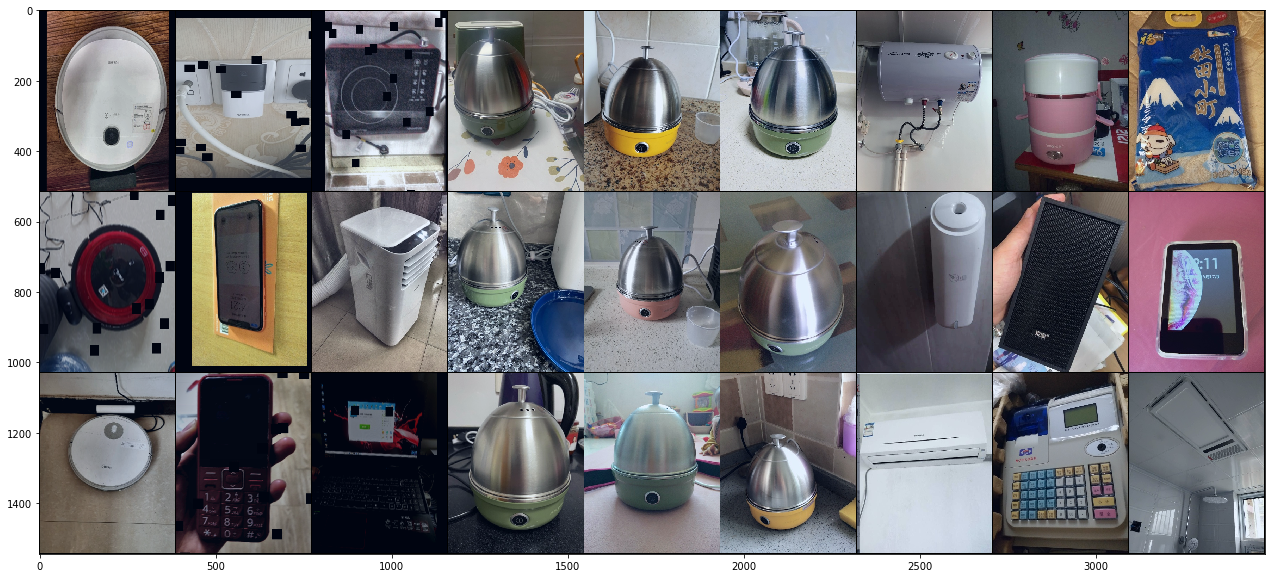

In [32]:
train_grid = torchvision.utils.make_grid(train_images, nrow=3, normalize=True, scale_each=False)
val_grid = torchvision.utils.make_grid(val_images, nrow=3, normalize=True, scale_each=True)
test_grid = torchvision.utils.make_grid(test_images, nrow=3, normalize=True, scale_each=True)
print(train_grid.shape, val_grid.shape, test_grid.shape)
grid = torch.cat([train_grid, val_grid, test_grid], dim=2)
plt.figure(figsize=(30, 10))
plt.imshow(grid.permute((1,2,0)).cpu())

# albu.Cutout()

## Implement metrics

### CMC score

In [49]:
_aspect_ratios = np.array([2, 16 / 9, 3 / 2, 4 / 3, 5 / 4, 1, 4 / 5, 3 / 4, 2 / 3, 9 / 16, 1 / 2])

df = pd.read_csv("data/interim/train_val.csv")
ar = df["aspect_ratio"].values
ar[:10]

array([0.75  , 1.    , 1.    , 0.75  , 1.    , 0.75  , 0.7486, 0.75  ,
       0.75  , 0.7486])

In [55]:
ar.reshape(-1, 1), _aspect_ratios.reshape(1, -1).shape

np.abs(_aspect_ratios.reshape(1, -1) - ar.reshape(-1, 1))
np.argmin(np.abs(_aspect_ratios.reshape(1, -1) - ar.reshape(-1, 1)), axis=1)

array([7, 5, 5, ..., 3, 2, 3])

In [4]:
sys.path.append("/home/zakirov/repoz/GPU-Efficient-Networks/")

import GENet

In [15]:
model = GENet.genet_normal(
    pretrained=True,
    num_classes=1000,
    root="/home/zakirov/repoz/GPU-Efficient-Networks/GENet_params")

# model.fc_linear = torch.nn.Linear(in_features=2560, out_features=512)
# torch.nn.init.xavier_uniform_(model.fc_linear.weight)

model.adptive_avg_pool.netblock = 

AdaptiveAvgPool2d(output_size=(1, 1))

# Show predictions

In [4]:
def show_predictions(query_idx, query_files, gallery_files, perm_matrix, topk=10):
    """Plots predictions"""
    predictions = gallery_files[perm_matrix[:,: topk][query_idx]]
    query_file = query_files[query_idx]
#     print(os.path.join("data/interim/test_data_A_384", query_file))
    
    query = cv2.imread(os.path.join("data/interim/test_data_A_384", query_file))
    query = cv2.cvtColor(query, cv2.COLOR_BGR2RGB)
    
    plt.figure(figsize=(20,15))
    plt.subplot(1, topk + 1, 1)
    plt.imshow(query)
    print(query_file, predictions)
    for i in range(topk - 1):
        image = cv2.imread(os.path.join("data/interim/test_data_A_384", predictions[i]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(1, topk + 1, i + 2)
        plt.imshow(image)

In [5]:
from loguru import logger
from src.callbacks import cmc_score_count, rank_map_score

In [6]:
# CONFIG_PATH = pathlib.Path("logs/resnet101_384_arcface_fp16_gem_light/")
# Val: Acc@1 0.81258, CMC@10 0.92955, mAP@10 0.80109, target 0.80683. In reality it's 0.56
# Val: Acc@1 0.81585, CMC@10 0.89858, mAP@10 0.81930, target 0.81758. topk=10, alpha=0, include_self=True
# Val: Acc@1 0.81294, CMC@10 0.88368, mAP@10 0.81732, target 0.81513. topk=10, alpha=0, inclues_self=True, with post renorm
# Val: Acc@1 0.80422, CMC@10 0.88462, mAP@10 0.80870, target 0.80646. topk=10, alpha=0, include_self=False
# CONFIG_PATH = pathlib.Path("logs/genet_normal_384_arcface_fp16_gem_light/") 
# Val: Acc@1 0.81018, CMC@10 0.92054, mAP@10 0.82022, target 0.81520
# Val: Acc@1 0.81294, CMC@10 0.88368, mAP@10 0.81732, target 0.81513. topk=10, alpha=0, inclues_self=True, with post renorm
# CONFIG_PATH = pathlib.Path("logs/genet_normal_512_cosface_fp16_gem_light/") 

CONFIG_PATH = pathlib.Path("logs/genet_512_arcface_05_gem_hard") 
df_test = pd.read_csv(CONFIG_PATH / "test_A.csv")

In [7]:
DBA = False
aQE = False

In [8]:
test_embeddings = torch.tensor(list(map(eval, df_test["embeddings"].values)))
query_mask = df_test["is_query"].values.astype(np.bool)
query_files, gallery_files = df_test["file_path"].values[query_mask], df_test["file_path"].values[~query_mask]

# Shape (n_embeddings, embedding_dim)
query_embeddings, gallery_embeddings = test_embeddings[query_mask], test_embeddings[~query_mask]
query_files, gallery_files = df_test["file_path"].values[query_mask], df_test["file_path"].values[~query_mask]
logger.info(f"Test query size - {len(query_embeddings)}, gallery size - {len(gallery_embeddings)}")
del test_embeddings

if DBA:
    gallery_embeddings = query_expansion(gallery_embeddings, gallery_embeddings, topk=10, alpha=None)

if aQE:
    query_embeddings = query_expansion(query_embeddings, gallery_embeddings, topk=3, alpha=3)

# Matrix of pairwise cosin distances
distances = torch.cdist(query_embeddings, gallery_embeddings)
perm_matrix = torch.argsort(distances)

2020-09-18 12:33:07.048 | INFO     | __main__:<module>:8 - Test query size - 9600, gallery size - 49804


query/01HMATBIX4CFKDS8.jpg ['gallery/3NOZG9VYMJ58S0U1.jpg' 'gallery/NDYQUHFXKVTCIORL.jpg'
 'gallery/5G8JI2CQW4TZD39Y.jpg' 'gallery/DLCE7UFQ3VTXG9R5.jpg'
 'gallery/IM1L85VBQ0YXJPEH.jpg' 'gallery/0FABH5NOQ4XVIDUG.jpg'
 'gallery/R1CUDLSXA49K7QOH.jpg' 'gallery/SVHRF0LTZIOWN8U1.jpg'
 'gallery/5FDZV7Y3L0IHES1Q.jpg' 'gallery/O1NV9RCHE3B5XW28.jpg']


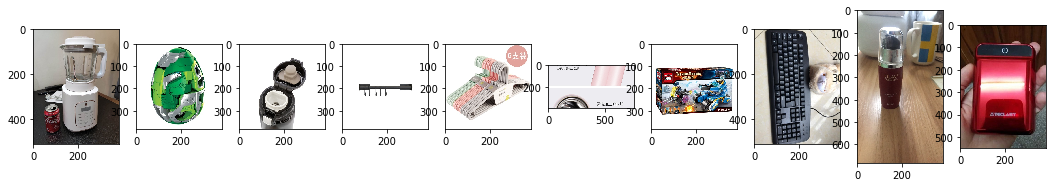

In [10]:
show_predictions(0, query_files, gallery_files, perm_matrix, topk=10)

In [ ]:
'01HMATBIX4CFKDS8.jpg,{3NOZG9VYMJ58S0U1.jpg,NDYQUHFXKVTCIORL.jpg,5G8JI2CQW4TZD39Y.jpg,DLCE7UFQ3VTXG9R5.jpg,IM1L85VBQ0YXJPEH.jpg,0FABH5NOQ4XVIDUG.jpg,R1CUDLSXA49K7QOH.jpg,SVHRF0LTZIOWN8U1.jpg,5FDZV7Y3L0IHES1Q.jpg,O1NV9RCHE3B5XW28.jpg}'

query/MA5WDJKUZP2XRLH7.jpg ['gallery/XM5RYEAVGP6SBQO9.jpg' 'gallery/G4HOI0ZQXS2WJKTR.jpg'
 'gallery/0OZ1KHN9DFA5IUXC.jpg' 'gallery/2Y6DOCN71M5HEWBP.jpg'
 'gallery/SAG4NM5RK902PTD3.jpg' 'gallery/3N0J745VEQGUAKZB.jpg'
 'gallery/7SAVLDUZCJRNFPBK.jpg' 'gallery/Q92Y37U0MO5BS4AT.jpg'
 'gallery/0GOKUMHY7QP2DJFE.jpg' 'gallery/RBJXWZNG201AMV3Y.jpg']


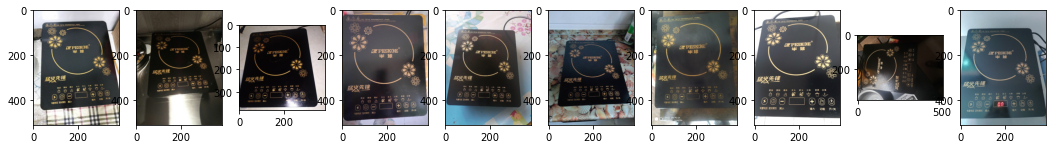

In [99]:
show_predictions(5955, query_files, gallery_files, perm_matrix, topk=10)

In [73]:
difficult_ids = [5985, ]
5955
5982
5957
5977 == 0

gallery/J76QAU305HYRCMZF.jpg'
 'gallery/2NL6ACGT73XRWF8Q.jpg' 'gallery/KNO8TIDP91W45V3F.jpg'
 'gallery/U8GX04I9TEZY36HA.jpg' 'gallery/LAPKNO0BZQFUCMD2.jpg'
 'gallery/5CJSA7LT41O36GWV.jpg' 'gallery/30PZ6EVAB9KH5UR4.jpg'
 'gallery/DVSCNG8I3THX14U2.jpg' 'gallery/8EV15HS2WCA409GI.jpg'

query/MCIGK4F97X310ZD6.jpg ['gallery/Z2LGCDPEYVWRJF8H.jpg' 'gallery/LAPKNO0BZQFUCMD2.jpg'
 'gallery/2NL6ACGT73XRWF8Q.jpg' 'gallery/MB0OXT2KFVWHJPNE.jpg'
 'gallery/INCWUHOB9VK5EP41.jpg' 'gallery/OF0D2Z1SLEWBRTHC.jpg'
 'gallery/NG8DPJZUFMIHBRCX.jpg' 'gallery/J76QAU305HYRCMZF.jpg'
 'gallery/L8MH4G2AXEUS3CTB.jpg' 'gallery/UD2MHOWQR4L0GE3Y.jpg']


5982

# Clean validation

In [286]:
from loguru import logger
from hashlib import md5

In [288]:
NUM_THREADS = 10
def get_single_hash(filename):
    """Returns: Tuple[hash, filename]"""
    with open(filename, "rb") as f:
        return md5(f.read()).hexdigest(), filename


def get_hash(filenames):
    """Returns list of hashes for files in filenames"""
    with multiprocessing.Pool(NUM_THREADS) as pool:
        result = list(tqdm(pool.imap(get_single_hash, filenames), total=len(filenames)))
    return result


In [416]:
root = pathlib.Path("data/raw")
output_path = pathlib.Path("data/")

logger.info("Creating train DF with additional metadata")
with open(root / "train_data/label.txt") as f:
    data = f.readlines()

filenames, labels = [], []
for row in data:
    file, label = row.strip("\n").split(",")
    filenames.append(file)
    labels.append(int(label))

df_data = {
    "file_path": filenames,
    "label": labels,
    "full_path": [root / "train_data" / file for file in filenames]
}
df = pd.DataFrame(data=df_data)

logger.info(f"Deleting duplicates, merging labels")
result = get_hash(df["full_path"])
df.sort_values(by="full_path", inplace=True)
hashes_md5 = [x[0] for x in sorted(result, key=lambda x: x[1])]
df["hash_md5"] = hashes_md5

2020-09-19 02:28:02.072 | INFO     | __main__:<module>:4 - Creating train DF with additional metadata
2020-09-19 02:28:02.652 | INFO     | __main__:<module>:21 - Deleting duplicates, merging labels


In [ ]:
print(len(df["label"].unique()))

In [417]:
print(len(df["label"].unique()))
df["label"] = df["label"].replace(LABEL_MAP)
df.drop_duplicates(subset="hash_md5", keep="first", inplace=True)
print(len(df["label"].unique()))

3088
3067


In [420]:
df[df.label == 1475]

,file_path,label,full_path,hash_md5
32583,DIGIX_001475/15YNTIUER8ZA97PO.jpg,1475,data/raw/train_data/DIGIX_001475/15YNTIUER8ZA9...,4b399b4df906eebf5cd62ee479a0e099
32582,DIGIX_001475/2R7W6CEZSF9OKXY8.jpg,1475,data/raw/train_data/DIGIX_001475/2R7W6CEZSF9OK...,347dd5d1eab43604694874bc5c0427c0
32578,DIGIX_001475/5KSL6UNC1MR49IPO.jpg,1475,data/raw/train_data/DIGIX_001475/5KSL6UNC1MR49...,c5699be8f0fbe63ff6102f19176c762d
32563,DIGIX_001475/78QD9R5V0IYXKWA2.jpg,1475,data/raw/train_data/DIGIX_001475/78QD9R5V0IYXK...,3088f85d969b48adc38287d94ffd7921
32577,DIGIX_001475/94VYAF87DLK0WZPG.jpg,1475,data/raw/train_data/DIGIX_001475/94VYAF87DLK0W...,9a3a573d74daceec431377e0a1017f14
32575,DIGIX_001475/9T06WA4QY82OVEND.jpg,1475,data/raw/train_data/DIGIX_001475/9T06WA4QY82OV...,286eb990fa3dcde40351fa73e0c14a0b
32562,DIGIX_001475/CXU2BHJTKE71Q8LZ.jpg,1475,data/raw/train_data/DIGIX_001475/CXU2BHJTKE71Q...,f7c14f3efe5dac6934d8240c4716b381
32568,DIGIX_001475/G367ZUYQXTL9MHWD.jpg,1475,data/raw/train_data/DIGIX_001475/G367ZUYQXTL9M...,5209e3e9d7fe28476192fb36e7b65430
32579,DIGIX_001475/HGY6V8P0OETW439S.jpg,1475,data/raw/train_data/DIGIX_001475/HGY6V8P0OETW4...,cdd9561177c5a3e816558863ea71cf98
32567,DIGIX_001475/HOXCIFUVY1KMDQ6E.jpg,1475,data/raw/train_data/DIGIX_001475/HOXCIFUVY1KMD...,0073d77371431dadba53b153665990b5


In [418]:
LABEL_MAP = {
    2979: 1475,
    1528: 1475,
    2113: 2672,
    1695: 2860,
    188: 1011,
    1697: 2714,
    499: 1937,
    1009: 1658,
    1534: 2244,
    1077: 1767,
    74: 1635,
    381: 2139,
    942: 2812,
    1082: 770,
    1205: 770,
    822: 2170,
    414: 939,
    30: 1390,
    841: 1663,
    756: 1870,
    968: 1807,
}

len(LABEL_MAP)

21

In [415]:
len(df)

68601

In [376]:
new_df = df[df.duplicated(subset="hash_md5")]

In [380]:
pd.set_option('display.max_rows', 205)

In [382]:
new_df[["label", "hash_md5"]].values

array([[26, '32b61279b86b2cdb0efee73328671538'],
       [26, '040b106bedb65ebbe4530229c23b6e73'],
       [28, '5a1960dad4ea94ee067f906c4f8331ea'],
       [89, '09f4f02f796cda1230617fb17dabb420'],
       [327, '94ff009ef0838212ed7f20aa8088fc36'],
       [329, '1297be4ea4aa3fa1a6891c85dac0a5d1'],
       [329, '4a174fb9e6d461695e8d008a5b1933fa'],
       [535, '406ec0b949961184f10522aa08585b63'],
       [535, 'a91bfbf7ba076f65f46bb60902678408'],
       [560, '50fc63573e406f5cb05a317cced514f3'],
       [724, '7b42765dbc30c1622aac6d05a88fbb31'],
       [786, '1bf601d33ea8a64ca2291aed148bc264'],
       [833, 'bccb7852d63fbc556f8fd93563379c5d'],
       [858, 'f8d72bdccd1d1eaa9f30902c01e1aeb3'],
       [939, 'f43a7c19d41d6e12eb272fcf6f1473c4'],
       [975, '1ba711f57661b475e02a565a36e70fe0'],
       [1009, 'cac0fa81e6402120170cdfa964c2713a'],
       [1011, 'c796ae6c864901268a956a7c27b42e96'],
       [1011, 'c2e40514bce43423d701894d71f98044'],
       [1011, '36166352479f953069ca0a9fdb4243a0'],


In [373]:
sorted(result, key=lambda x: x[1])[:5]

[('b2a51756bcc2747e9c2b1705e2698c48',
  PosixPath('data/raw/train_data/DIGIX_000000/19BRS2LZXV4M865W.jpg')),
 ('bbb1b8013cf2b3070504e7430413a9f1',
  PosixPath('data/raw/train_data/DIGIX_000000/4M83NC5JGYK0SP2Q.jpg')),
 ('61229d8d436ebbae740b345c8e07b7df',
  PosixPath('data/raw/train_data/DIGIX_000000/5W97AIZ2CE43XHQD.jpg')),
 ('06c03ce2c568bc0d27db07c8e5535f8d',
  PosixPath('data/raw/train_data/DIGIX_000000/7WMZS8Q2V06E54FL.jpg')),
 ('d8e8ab226a48cace35741c8e605394b7',
  PosixPath('data/raw/train_data/DIGIX_000000/9AYO2KC0ZLM3VU78.jpg'))]

In [367]:
# df["tmp"] = range(len(df))
i = df.groupby(["label", "hash_md5",]).filter(lambda x: len(x)  1).index
# i = df[df["hash_md5"].isin(same_class_duplicates)].index
# df.iloc[i, df.columns.get_loc("tmp")] = -1
i

Int64Index([  581,   586,   574,   568,   625,   620,  2115,  2107,  7739,
             7711,  7773,  7760,  7757,  7758, 11945, 11937, 11935, 11941,
            12475, 12481, 15795, 15798, 17223, 17219, 18096, 18103, 18806,
            18793, 21388, 21371, 22060, 22076, 25372, 25352, 26665, 26641,
            28168, 28173, 28834, 28838, 32757, 32759, 33175, 33150, 33402,
            33374, 36147, 36138, 38293, 38309, 39611, 39604, 44586, 44563,
            45860, 45854, 46621, 46632, 50848, 50844, 52405, 52404, 56816,
            56817, 57921, 57919, 61751, 61739, 62883, 62861, 64081, 64057,
            64925, 64929, 65539, 65548, 66391, 66396, 68556, 68565, 68549,
            68548, 68583, 68581],
           dtype='int64')

In [362]:
pd.set_option('display.max_rows', 100)

In [370]:
df.iloc[i].sort_values(by=["label", "hash_md5"])

,file_path,label,full_path,hash_md5
577,DIGIX_000026/9N6LPY5SHF3XMG4E.jpg,26,data/raw/train_data/DIGIX_000026/9N6LPY5SHF3XM...,033f0b60b1f580ffd275f5667e3386d6
581,DIGIX_000026/G8MYW6F0ZB2ASROX.jpg,26,data/raw/train_data/DIGIX_000026/G8MYW6F0ZB2AS...,32b61279b86b2cdb0efee73328671538
563,DIGIX_000026/V9UF84Z75PHTB2WR.jpg,26,data/raw/train_data/DIGIX_000026/V9UF84Z75PHTB...,837b74d70f9218895f9fd68a1792386c
573,DIGIX_000026/ONCS6BMA0E1GRQK7.jpg,26,data/raw/train_data/DIGIX_000026/ONCS6BMA0E1GR...,9867b00a2635b3ba51c18ebbabbe5afe
617,DIGIX_000028/RVHT7P0I9QM13ZYL.jpg,28,data/raw/train_data/DIGIX_000028/RVHT7P0I9QM13...,9c119380990b7478ec25f7a4b34814bb
618,DIGIX_000028/XD6VE34HCJLKPYZR.jpg,28,data/raw/train_data/DIGIX_000028/XD6VE34HCJLKP...,da3eae7a27aee38fbeaea8a4c9428eb5
2115,DIGIX_000089/2VAE9QYM0OB4N51I.jpg,89,data/raw/train_data/DIGIX_000089/2VAE9QYM0OB4N...,09f4f02f796cda1230617fb17dabb420
2113,DIGIX_000089/L2TOXBESAVFI7P53.jpg,89,data/raw/train_data/DIGIX_000089/L2TOXBESAVFI7...,ce61889fcff789b730d4815470706a6a
7745,DIGIX_000327/1QBJRV52CATOYPNU.jpg,327,data/raw/train_data/DIGIX_000327/1QBJRV52CATOY...,a155b2266f098ba59ef723e29936626a
7723,DIGIX_000327/XHCUN8TZFJ52PKGB.jpg,327,data/raw/train_data/DIGIX_000327/XHCUN8TZFJ52P...,c639b3bd4681f452cacecd25d80bb489


In [354]:
df["tmp"] = range(len(df))
same_class_duplicates = df.groupby(["hash_md5", "label"]).filter(lambda x: len(x) > 1)["hash_md5"].unique()
i = df[df["hash_md5"].isin(same_class_duplicates)].index
df.iloc[i, df.columns.get_loc("tmp")] = -1

In [355]:
new_df = df.drop_duplicates(subset=["tmp", "hash_md5"], keep="first", inplace=False)

In [356]:
len(new_df)

68803

In [350]:
df[df["full_path"] == 'test']

,file_path,label,full_path,hash_md5
577,DIGIX_000026/9N6LPY5SHF3XMG4E.jpg,26,test,033f0b60b1f580ffd275f5667e3386d6
581,DIGIX_000026/G8MYW6F0ZB2ASROX.jpg,26,test,32b61279b86b2cdb0efee73328671538
573,DIGIX_000026/ONCS6BMA0E1GRQK7.jpg,26,test,9867b00a2635b3ba51c18ebbabbe5afe
563,DIGIX_000026/V9UF84Z75PHTB2WR.jpg,26,test,837b74d70f9218895f9fd68a1792386c
617,DIGIX_000028/RVHT7P0I9QM13ZYL.jpg,28,test,9c119380990b7478ec25f7a4b34814bb
...,...,...,...,...
68561,DIGIX_003086/95TKDMEV7SJ41AOZ.jpg,3086,test,6c276d2ce419a3253ebeb6595dd5c5ba
68555,DIGIX_003086/J381PBL6YWMF5NK7.jpg,3086,test,11bec174cbfd476f453d91828757bd0c
68548,DIGIX_003086/Y4A9OJSDXH8P723I.jpg,3086,test,219864eb27e35790b7d4da7b519d363d
68586,DIGIX_003087/FIQ7NWPKLJCV9YTS.jpg,3087,test,ad7161612ba14d27bc3c8bf6e399f560


In [318]:
diplicates_df

,file_path,label,full_path,hash_md5,same_group_duplicate
581,DIGIX_000026/G8MYW6F0ZB2ASROX.jpg,26,data/raw/train_data/DIGIX_000026/G8MYW6F0ZB2AS...,32b61279b86b2cdb0efee73328671538,True
586,DIGIX_000026/GILB7RM0XCO5DU3Y.jpg,26,data/raw/train_data/DIGIX_000026/GILB7RM0XCO5D...,32b61279b86b2cdb0efee73328671538,True
574,DIGIX_000026/WNEIYBDFSRM2AXL8.jpg,26,data/raw/train_data/DIGIX_000026/WNEIYBDFSRM2A...,040b106bedb65ebbe4530229c23b6e73,True
568,DIGIX_000026/Y69F81QU4BEZWJX7.jpg,26,data/raw/train_data/DIGIX_000026/Y69F81QU4BEZW...,040b106bedb65ebbe4530229c23b6e73,True
625,DIGIX_000028/2I1K9GEYP3UJHC4B.jpg,28,data/raw/train_data/DIGIX_000028/2I1K9GEYP3UJH...,5a1960dad4ea94ee067f906c4f8331ea,True
...,...,...,...,...,...
68565,DIGIX_003086/JHNBRX603PLQTMSG.jpg,3086,data/raw/train_data/DIGIX_003086/JHNBRX603PLQT...,f34360b590c47fe992263fefc91c1e32,True
68549,DIGIX_003086/RVBK9QSLT5UGA1CW.jpg,3086,data/raw/train_data/DIGIX_003086/RVBK9QSLT5UGA...,f34360b590c47fe992263fefc91c1e32,True
68548,DIGIX_003086/Y4A9OJSDXH8P723I.jpg,3086,data/raw/train_data/DIGIX_003086/Y4A9OJSDXH8P7...,219864eb27e35790b7d4da7b519d363d,True
68583,DIGIX_003087/BQDRWTC178FXZEM5.jpg,3087,data/raw/train_data/DIGIX_003087/BQDRWTC178FXZ...,1d2fe2d9653ccaecb5cb553fc73bc704,True


In [319]:
len(df)

68805

In [320]:
diplicates_df["same_group_duplicate"] = True
df["same_group_duplicate"] = False

In [322]:
new_df = pd.merge(df, diplicates_df[["file_path","same_group_duplicate"]] , how="left", on=["file_path","same_group_duplicate"]).sort_values(by=["file_path"])#.reset_index(drop=True)



,file_path,label,full_path,hash_md5,same_group_duplicate
0,DIGIX_000000/19BRS2LZXV4M865W.jpg,0,data/raw/train_data/DIGIX_000000/19BRS2LZXV4M8...,b2a51756bcc2747e9c2b1705e2698c48,False
1,DIGIX_000000/4M83NC5JGYK0SP2Q.jpg,0,data/raw/train_data/DIGIX_000000/4M83NC5JGYK0S...,bbb1b8013cf2b3070504e7430413a9f1,False
2,DIGIX_000000/5W97AIZ2CE43XHQD.jpg,0,data/raw/train_data/DIGIX_000000/5W97AIZ2CE43X...,61229d8d436ebbae740b345c8e07b7df,False
3,DIGIX_000000/7WMZS8Q2V06E54FL.jpg,0,data/raw/train_data/DIGIX_000000/7WMZS8Q2V06E5...,06c03ce2c568bc0d27db07c8e5535f8d,False
4,DIGIX_000000/9AYO2KC0ZLM3VU78.jpg,0,data/raw/train_data/DIGIX_000000/9AYO2KC0ZLM3V...,d8e8ab226a48cace35741c8e605394b7,False
...,...,...,...,...,...
68800,DIGIX_003096/TZBL6RX8PSVIM9NU.jpg,3096,data/raw/train_data/DIGIX_003096/TZBL6RX8PSVIM...,40113f6540350e7f9f867d3ab4237b5e,False
68801,DIGIX_003096/UZQ76G8350EMYA4K.jpg,3096,data/raw/train_data/DIGIX_003096/UZQ76G8350EMY...,33333f6a1e7b4ad2adb03515fe5dd758,False
68802,DIGIX_003096/WSLC4T2ME7YVDHGA.jpg,3096,data/raw/train_data/DIGIX_003096/WSLC4T2ME7YVD...,09ce66c64afe7eb62cbabce4f7c89e18,False
68803,DIGIX_003096/WUY8RFOC49ZXNI6T.jpg,3096,data/raw/train_data/DIGIX_003096/WUY8RFOC49ZXN...,8752611b8c3dd2edeca40cf3153c91a5,False


In [316]:
new_df.same_group_duplicate.values

array([False, False, False, ..., False, False, False])

In [ ]:
    # Merge
    df = pd.merge(df, df_meta, how="inner", on="image").sort_values(by=["image"]).reset_index(drop=True)

In [296]:
diplicates_df = df.groupby("hash_md5").filter(lambda x: len(x) > 1)
diplicates_df

,file_path,label,full_path,hash_md5
581,DIGIX_000026/G8MYW6F0ZB2ASROX.jpg,26,data/raw/train_data/DIGIX_000026/G8MYW6F0ZB2AS...,32b61279b86b2cdb0efee73328671538
586,DIGIX_000026/GILB7RM0XCO5DU3Y.jpg,26,data/raw/train_data/DIGIX_000026/GILB7RM0XCO5D...,32b61279b86b2cdb0efee73328671538
574,DIGIX_000026/WNEIYBDFSRM2AXL8.jpg,26,data/raw/train_data/DIGIX_000026/WNEIYBDFSRM2A...,040b106bedb65ebbe4530229c23b6e73
568,DIGIX_000026/Y69F81QU4BEZWJX7.jpg,26,data/raw/train_data/DIGIX_000026/Y69F81QU4BEZW...,040b106bedb65ebbe4530229c23b6e73
625,DIGIX_000028/2I1K9GEYP3UJHC4B.jpg,28,data/raw/train_data/DIGIX_000028/2I1K9GEYP3UJH...,5a1960dad4ea94ee067f906c4f8331ea
...,...,...,...,...
68565,DIGIX_003086/JHNBRX603PLQTMSG.jpg,3086,data/raw/train_data/DIGIX_003086/JHNBRX603PLQT...,f34360b590c47fe992263fefc91c1e32
68549,DIGIX_003086/RVBK9QSLT5UGA1CW.jpg,3086,data/raw/train_data/DIGIX_003086/RVBK9QSLT5UGA...,f34360b590c47fe992263fefc91c1e32
68548,DIGIX_003086/Y4A9OJSDXH8P723I.jpg,3086,data/raw/train_data/DIGIX_003086/Y4A9OJSDXH8P7...,219864eb27e35790b7d4da7b519d363d
68583,DIGIX_003087/BQDRWTC178FXZEM5.jpg,3087,data/raw/train_data/DIGIX_003087/BQDRWTC178FXZ...,1d2fe2d9653ccaecb5cb553fc73bc704


In [256]:
len(test_hashes) - len(set(test_hashes))

106

In [273]:
def checkio(data):
    for index in tqdm(range(len(data) - 1, -1, -1)):
        if data.count(data[index]) == 1:
            del data[index]
    return data

duplicates_train = checkio(train_hashes)
# unique_test = checkio(test_hashes)

In [275]:
pairs = []
for duplicate_hash in tqdm(duplicates_train):
    local_pairs = []
    for x in train_result:
        if x[0] == duplicate_hash:
            local_pairs.append(x[1])
    pairs.append(local_pairs)

In [390]:
len("data/raw/train_data/DIGIX_")

26

In [407]:
pairs

same_class = []
diff_class = []
for p in pairs:
    if p[0][:33] == p[1][:33]:
        same_class.append(int(p[0][26:32]))
    else:
        diff_class.append((int(p[1][26:32]), int(p[0][26:32])))
        

In [409]:
set(diff_class)

{(939, 414),
 (1011, 188),
 (1082, 770),
 (1205, 770),
 (1390, 30),
 (1528, 1475),
 (1635, 74),
 (1658, 1009),
 (1663, 841),
 (1767, 1077),
 (1807, 968),
 (1870, 756),
 (1937, 499),
 (2139, 381),
 (2170, 822),
 (2244, 1534),
 (2672, 2113),
 (2714, 1697),
 (2812, 942),
 (2860, 1695),
 (2979, 1475)}

In [403]:
print(len(set(diff_class)))

21


In [398]:
dict(set(diff_class))

{2979: 1475,
 1528: 1475,
 2113: 2672,
 1695: 2860,
 188: 1011,
 1697: 2714,
 499: 1937,
 1009: 1658,
 1534: 2244,
 1077: 1767,
 74: 1635,
 381: 2139,
 942: 2812,
 1082: 770,
 1205: 770,
 822: 2170,
 414: 939,
 30: 1390,
 841: 1663,
 756: 1870,
 968: 1807}

{1475: 2979,
 2113: 2672,
 1695: 2860,
 188: 1011,
 1697: 2714,
 499: 1937,
 1009: 1658,
 1534: 2244,
 1077: 1767,
 74: 1635,
 381: 2139,
 942: 2812,
 770: 1082,
 822: 2170,
 414: 939,
 30: 1390,
 841: 1663,
 756: 1870,
 968: 1807}

In [258]:
unique_train = set(unique_train)
duplicate_files_train = []
for x in train_result:
    if x[0] in unique_train:
        duplicate_files_train.append(x[1])

In [259]:
unique_test = set(unique_test)
duplicate_files_test = []
for x in test_result:
    if x[0] in unique_test:
        duplicate_files_test.append(x[1])

In [137]:
# duplicate_files_test

In [262]:
len(duplicate_files_train)

408

# Diffusion

In [4]:
import faiss

ModuleNotFoundError: No module named 'faiss'